## Test stockprice prediction

In [42]:
import yfinance as yf
import torch
from torch import nn
import numpy as np
import math
import time
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
import pandas as pd
from torch.utils.data import Dataset, DataLoader,ConcatDataset
import matplotlib.pyplot as plt


In [61]:
# Load historical data for BNP Paribas
# df = yf.download('BNP.PA', start='2000-01-01', end='2024-11-12')
df = yf.download('BNP.PA')
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [62]:
df.head()
df.tail()

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,BNP.PA,BNP.PA,BNP.PA,BNP.PA,BNP.PA,BNP.PA
8039,2024-12-19 00:00:00+00:00,57.810001,57.810001,58.090000,57.220001,57.580002,2800740
8040,2024-12-20 00:00:00+00:00,57.480000,57.480000,57.599998,56.599998,57.360001,4839471
8041,2024-12-23 00:00:00+00:00,57.439999,57.439999,57.529999,57.009998,57.520000,1395481
8042,2024-12-24 00:00:00+00:00,57.540001,57.540001,57.910000,57.540001,57.820000,479686
8043,2024-12-27 00:00:00+00:00,58.540001,58.540001,58.669998,57.900002,57.900002,2338135


8044


/tmp/ipykernel_4929/4200131804.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['Date'][1]


Timestamp('1993-10-19 00:00:00+0000', tz='UTC')

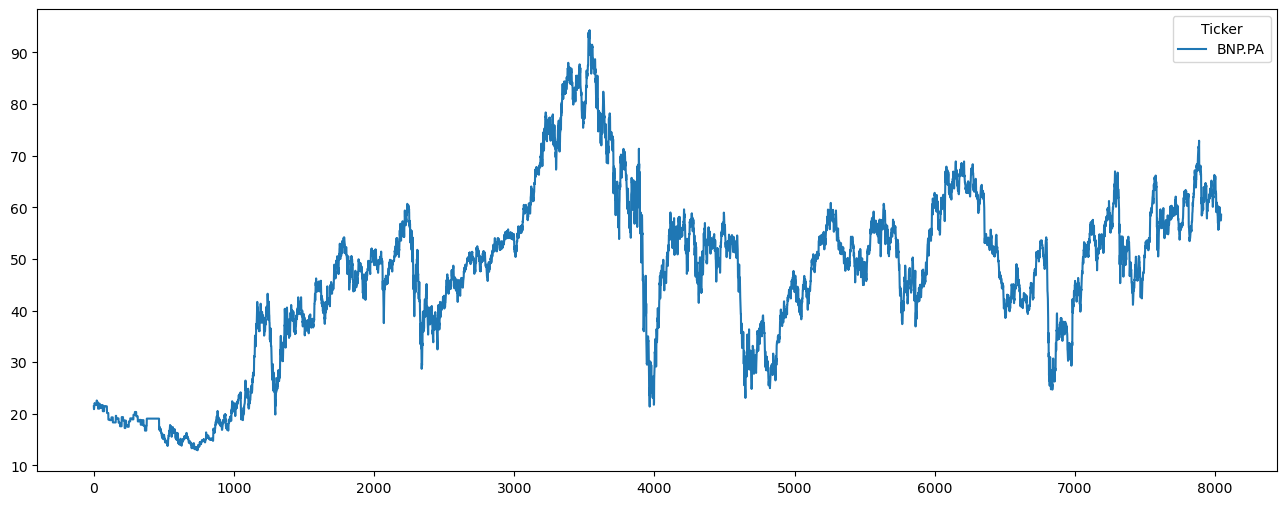

In [63]:
df['Close'].plot(figsize=(16,6))
# dat = df[['Close']].astype('float32')
# dat.rolling(window=30).mean()['Close'].plot()
df.index = pd.to_datetime(df.index)
print(len(df))
df['Date'][1]


## Select Close and scale
make sure that df is not yet scaled

In [64]:
df = df.drop(columns=['Date', 'Adj Close','Volume','Open', 'High','Low'])
columns = df.columns
scaler = MinMaxScaler(feature_range=(0,1))
df[columns] = scaler.fit_transform(df[columns])
df.reset_index(inplace=True)
print(df.head())

min_original = scaler.data_min_
max_original = scaler.data_max_
print('Min value: ', min_original, 'Max value:', max_original)
# df['Close'].plot(figsize=(16,6))

Price                          index     Close
Ticker                                  BNP.PA
0      1970-01-01 00:00:00.000000000  0.104577
1      1970-01-01 00:00:00.000000001  0.097889
2      1970-01-01 00:00:00.000000002  0.099713
3      1970-01-01 00:00:00.000000003  0.103969
4      1970-01-01 00:00:00.000000004  0.110049
Min value:  [12.91] Max value: [94.3]


/tmp/ipykernel_4929/3734569726.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns=['Date', 'Adj Close','Volume','Open', 'High','Low'])


/tmp/ipykernel_4929/1331366247.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df['Close',].plot(figsize=(16,6))


Price,index,Close
Ticker,,BNP.PA
8039,1970-01-01 00:00:00.000008039,0.551637
8040,1970-01-01 00:00:00.000008040,0.547583
8041,1970-01-01 00:00:00.000008041,0.547091
8042,1970-01-01 00:00:00.000008042,0.548320
8043,1970-01-01 00:00:00.000008043,0.560607


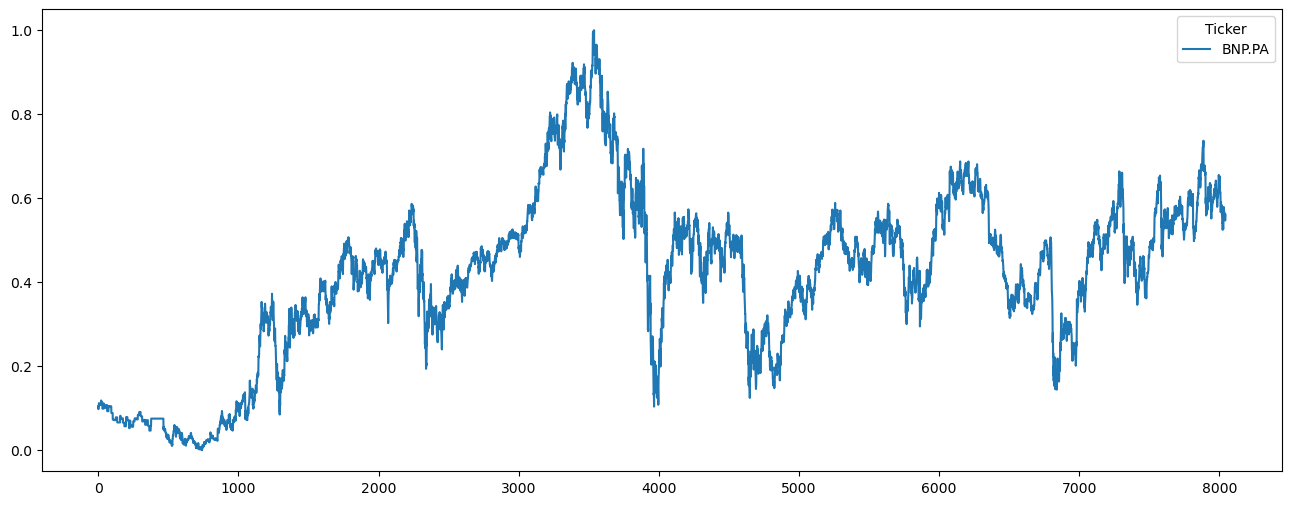

In [65]:
df['Close',].plot(figsize=(16,6))
df.tail()


## Generate train and target scaled data

In [66]:
# train_df = df[['Close']].drop(df.index[:7000]) # select last 3000 rows for training
train_df = df[['Close']]
data = torch.tensor(train_df[['Close']].values)
train_data = train_df["Close"].values.reshape(-1)
# print(df.head())
# print(train_df.tail())
# print(len(data))

print(train_data,train_data.shape)
train_df.head()

[0.1  0.1  0.1  ... 0.55 0.55 0.56] (8044,)


Price,Close
Ticker,BNP.PA
0,0.104577
1,0.097889
2,0.099713
3,0.103969
4,0.110049


## Meta data

In [67]:
device = torch.device("cuda:0")
batch_size = 100 # batch size
sequence_size = 10
feature_size = 99 # number of features (close price)
# vocab_size = 10000
input_window = sequence_size
output_window = 1

In [68]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq).to(device)

In [69]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

In [70]:
def get_data(data, split):
    """Split ratio of training data"""

    series = data
    
    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    # train_data = train_data.cumsum()
    # train_data = 2*train_data # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
    #                           # Similar to image transformation to allow model to train on wider data sets

    # test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

## Testing data

In [ ]:
train_data = np.arange(0,40,1)
X_train = train_data.reshape(-1,2,4)
print(X_train,X_train.shape)
x = torch.FloatTensor(X_train)
x_res = x[:,:,3:] # select last column
print(x_res,x_res.shape)
# print(x_mean, x_mean.shape)

In [ ]:
print(train_data.shape,type(train_data))
dat = create_inout_sequences(train_data,input_window)
# dat1 = dat[:,-output_window].unsqueeze(0)
print('dat:',dat,dat.shape)
# print(dat1,dat1.shape)
# batch_size = 1
i = 0
inp,targ = get_batch(dat,i,1)
print('inp:',inp,inp.shape)
print('targ:',targ,targ.shape)

train_sequence, val_sequence = get_data(train_data,0.6)
print('train_sequence:',train_sequence, train_sequence.shape)

# x_train = torch.tensor(train_data).float()
# print(x_train, x_train.shape)
# resul = torch.stack(torch.stack([item[0] for item in x_train]).chunk(input_window, 1))
# print(resul, resul.shape)
# seq = np.pad(train_data[8000:8000+10], (0, 3), mode='constant', constant_values=(0, 0))
# print(seq)
# dat1 = create_inout_sequences(seq,input_window)
# print(dat1,dat1.shape)

## Define modules

## Time2Vec    

ref: Andrew Garcia
https://github.com/andrewrgarcia/time2vec

The input data has N+1 features including time, where time is numeric eg Unix time, or time delta since last event, or whatever. This means there are N features that are not time. 

Time2vec layer is applied once before every other layer. 

The N feature variables are passed through the Time2vec layer unchanged. 

The time variable in andrewrgarcia's github implementation is taken from the rightmost column [-1:]

The time variable is transformed into k+1 features - K frequencies using w.sin(t)+b each plus a scalar value. 

The Time2vec layer takes in N+1 features and outputs N+K+1 features.

The Time2vec layer has (K+1)w weights + (K+1) bias weights, ie a w weight and a b weight for every periodic time feature plus one w and b for the longest time feature.  8. Unless there's a specifically good reason not to, all variables should be scaled after the Time2vec layer eg batch normalised 

Since this involves a sin function that partly relies on times ever increasing value (ie for the linear/non periodic value) the time variable should not be scaled/normalised before the Time2vec layer. 

When coded right (the bit I need to relearn) the frequency weights w & b are learned, but nothing affects the other N non-time variables at this layer since they're set to an identity function. 


In [71]:
class Time2Vec(nn.Module):
    def __init__(self, num_frequency=2, num_vars=4):
        """
        Custom PyTorch object for Time2Vec Transformation.

        Parameters
        -------------
        num_frequency: int
            The number of periodic components to model.
        num_vars: int
            The number of variables to consider from the input.
        """
        super(Time2Vec, self).__init__()
        self.num_frequency = num_frequency
        self.num_vars = num_vars

        self.trend_weight = nn.Parameter(torch.Tensor(1)).to(device)
        self.trend_bias = nn.Parameter(torch.Tensor(1)).to(device)

        # Placeholder for periodic weights and bias; will be initialized in forward
        self.periodic_weight = None
        self.periodic_bias = None

        nn.init.uniform_(self.trend_weight)
        nn.init.uniform_(self.trend_bias)

    def forward(self, inputs):
        # Split inputs into x and t
        x = inputs[:, :, :self.num_vars-1]
        t = inputs[:, :, self.num_vars-1:]

        # Initialize periodic weights and bias based on input shape
        if self.periodic_weight is None:
            input_shape = inputs.shape
            self.periodic_weight = nn.Parameter(torch.Tensor(input_shape[-1] - self.num_vars + 1, self.num_frequency)).to(device)
            # self.periodic_bias = nn.Parameter(torch.Tensor(input_shape[1], self.num_frequency)).to(device)
            self.periodic_bias = nn.Parameter(torch.Tensor(1, self.num_frequency)).to(device)
            nn.init.uniform_(self.periodic_weight)
            nn.init.uniform_(self.periodic_bias)
        
        # Trend component
        trend_component = self.trend_weight * t + self.trend_bias

        # Periodic component
        periodic_component = torch.sin(torch.matmul(t, self.periodic_weight) + self.periodic_bias)

        # Concatenate trend and periodic components
        t_encoded = torch.cat([trend_component, periodic_component], dim=-1)

        # Concatenate x and t_encoded
        output = torch.cat([x, t_encoded], dim=-1)
        
        return output

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        # pe[:, 1::2] = torch.cos(position * div_term)
        if d_model%2 != 0:
            pe[:, 1::2] = torch.cos(position * div_term)[:,0:-1]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


## Testing Time2Vec

In [ ]:
train_data = np.arange(0,40,1)
X_train = train_data.reshape(-1,2,1)
x = torch.FloatTensor(X_train).to(device)

num_vars = 1
num_frequency = 99
inputs = x
input_shape = inputs.shape
print(input_shape[1],input_shape[-1])
x1 = inputs[:, :, :num_vars-1]
t = inputs[:, :, num_vars-1:]
print(x1.shape,t.shape)

periodic_weight = nn.Parameter(torch.Tensor(input_shape[-1] - num_vars + 1, num_frequency))
print(periodic_weight,periodic_weight.shape)
periodic_bias = nn.Parameter(torch.Tensor(input_shape[1], num_frequency))
print(periodic_bias,periodic_bias.shape)
mod = Time2Vec(99,1)
out = mod(inputs)
# print(out,out.shape)
print(out.shape)



In [ ]:
inp,targ = get_batch(train_sequence,i,1)
x = inp
x.to(device)
print(x,x.shape)
num_vars = 1
num_frequency = 99
mod = Time2Vec(99,1)
out  = mod(x).to(device)
print(out,out.shape)

## Define models

In [72]:
class TimeserealModel(nn.Module):
    def __init__(self, feature_size=feature_size):
        super(TimeserealModel, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.time_embedding = Time2Vec(num_frequency=feature_size,num_vars=1)
        # self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size+1, nhead=10, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)        
        self.decoder = nn.Linear(feature_size+1,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        # print('src:',src.shape)
        # src = self.pos_encoder(src)
        src = self.time_embedding(src)
        # print('pos_enc:', src.shape)
        output = self.transformer_encoder(src,self.src_mask)
        # print('transforme:',src.shape)
        output = self.decoder(output)
        # print('out:',output.shape)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

## Train

In [20]:
model = TimeserealModel(feature_size=feature_size).to(device)
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
best_loss = float('inf')
train_sequence, val_sequence = get_data(train_data, 0.6) # 60% train, 40% test split
print(train_sequence.shape)


for epoch in range(100):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch_idx, i in enumerate(range(0, len(train_sequence) - 1, batch_size)):
        data, targets = get_batch(train_sequence, i, batch_size)
        # print(i,data.shape)
        if data.size(dim=1)==100:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            optimizer.step()
    scheduler.step()  # Update learning rate here
    print(f'Epoch {epoch}, Batch {batch_idx+1}: Loss = {loss.item():.4f}, lr={optimizer.param_groups[0]["lr"]:.7f}')
    if loss.item() < best_loss:
        # torch.save(model.state_dict(), '/home/avncalst/Dropbox/deeplearning/SSD/RealTimeObjectDetection/Tensorflow/workspace/datasets/model_dir/torch/model_finan1.pth')
        torch.save(model, '/home/avncalst/Dropbox/deeplearning/SSD/RealTimeObjectDetection/Tensorflow/workspace/datasets/model_dir/torch/model_finan1.pth')
        best_loss = loss.item()
        print(f'loss improved -> model saved')


/home/avncalst/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


torch.Size([4814, 2, 10])
Epoch 0, Batch 49: Loss = 0.0092, lr=0.0000475
loss improved -> model saved
Epoch 1, Batch 49: Loss = 0.2231, lr=0.0000451
Epoch 2, Batch 49: Loss = 0.0380, lr=0.0000429
Epoch 3, Batch 49: Loss = 0.0370, lr=0.0000407
Epoch 4, Batch 49: Loss = 0.0995, lr=0.0000387
Epoch 5, Batch 49: Loss = 0.1061, lr=0.0000368
Epoch 6, Batch 49: Loss = 0.1566, lr=0.0000349
Epoch 7, Batch 49: Loss = 0.1238, lr=0.0000332
Epoch 8, Batch 49: Loss = 0.0572, lr=0.0000315
Epoch 9, Batch 49: Loss = 0.0272, lr=0.0000299
Epoch 10, Batch 49: Loss = 0.0096, lr=0.0000284
Epoch 11, Batch 49: Loss = 0.0107, lr=0.0000270
Epoch 12, Batch 49: Loss = 0.0109, lr=0.0000257
Epoch 13, Batch 49: Loss = 0.0269, lr=0.0000244
Epoch 14, Batch 49: Loss = 0.0389, lr=0.0000232
Epoch 15, Batch 49: Loss = 0.0445, lr=0.0000220
Epoch 16, Batch 49: Loss = 0.0093, lr=0.0000209
Epoch 17, Batch 49: Loss = 0.0119, lr=0.0000199
Epoch 18, Batch 49: Loss = 0.0022, lr=0.0000189
loss improved -> model saved
Epoch 19, Batc

## Predict stockprice

Function to forecast 1 time step from window sequence

In [27]:
def model_forecast(model, seqence):
    model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):            
            output = model(seq[-output_window:])                        
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

Function to forecast entire sequence

In [73]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval() 
    forecast_seq = torch.Tensor(0)    
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            dat, targ = get_batch(sequences, i, batch_size=1)
            print(dat.shape)
            output = model(dat)            
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, targ[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

Test forecast

In [ ]:
train_sequence, val_sequence = get_data(train_data, 0.6) # 60% train, 40% test split
print(val_sequence.shape)
# state_dict = torch.load('/home/avncalst/Dropbox/deeplearning/SSD/RealTimeObjectDetection/Tensorflow/workspace/datasets/model_dir/torch/model_finan1.pth')
# model_eval = TimeserealModel(feature_size=feature_size).to(device)
# model_eval.to(device)
# model_eval.load_state_dict(state_dict=state_dict)
model_eval = torch.load('/home/avncalst/Dropbox/deeplearning/SSD/RealTimeObjectDetection/Tensorflow/workspace/datasets/model_dir/torch/model_finan1.pth')
model_eval.to(device)
model_eval.eval()
test_result, truth = forecast_seq(model_eval, val_sequence)
# test_result, truth = forecast_seq(model, val_sequence)
# Calculate the rolling average with a window size of 10
window_size = 10
truth_rolling_avg = np.convolve(truth, np.ones(window_size)/window_size, mode='valid')
test_result = test_result * (max_original - min_original) + min_original
truth = truth * (max_original - min_original) + min_original
truth_rolling_avg = truth_rolling_avg * (max_original - min_original) + min_original

plt.plot(truth, color='red', alpha=0.7)
# Shift the rolling average to match the original sequence (since convolve changes the sequence length)
plt.plot(np.arange(len(truth)-window_size+1) + window_size - 1, truth_rolling_avg, color='green')
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Rolling Average','Forecast'])
plt.xlabel('Time Steps')
plt.show()

plot results

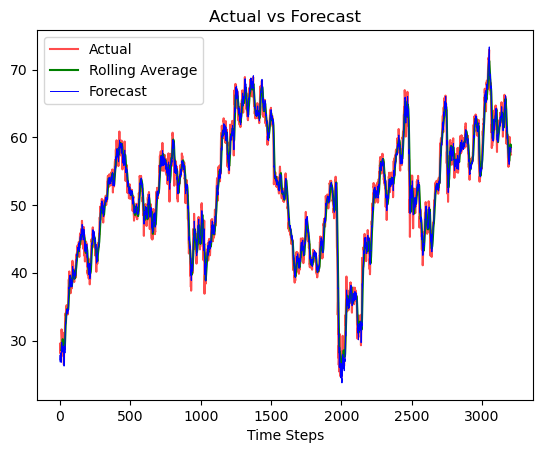

In [76]:
plt.plot(truth, color='red', alpha=0.7)
# Shift the rolling average to match the original sequence (since convolve changes the sequence length)
plt.plot(np.arange(len(truth)-window_size+1) + window_size - 1, truth_rolling_avg, color='green')
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Rolling Average','Forecast'])
plt.xlabel('Time Steps')
plt.show()

zoom results

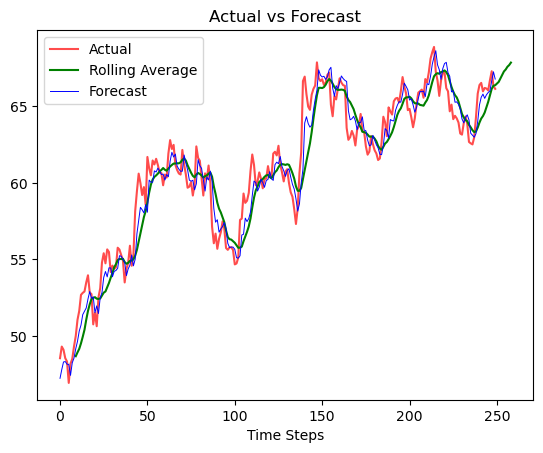

In [75]:
plt.plot(truth[1100:1350], color='red', alpha=0.7)
# Shift the rolling average to match the original sequence (since convolve changes the sequence length)
plt.plot((np.arange(len(truth)-window_size+1)[1100:1350] + window_size - 1)-1100, truth_rolling_avg[1100:1350], color='green')
plt.plot(test_result[1100:1350], color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Rolling Average','Forecast'])
plt.xlabel('Time Steps')
plt.show()

## Test random sequence

In [ ]:
model_eval = torch.load('/home/avncalst/Dropbox/deeplearning/SSD/RealTimeObjectDetection/Tensorflow/workspace/datasets/model_dir/torch/model_finan1.pth')
model_eval.to(device)
model_eval.eval()


r=8000
test_forecast = model_forecast(model_eval, train_data[r: r+10]) # random 10 sequence length

np.set_printoptions(precision=2)
print(f"forecast sequence: {test_forecast* (max_original - min_original) + min_original}")
print(f"Actual sequence: {train_data[r: r+11]* (max_original - min_original) + min_original}")



forecast sequence: [65.33 66.02 65.94 65.5  62.75 63.04 62.87 62.74 61.07 59.05 58.83]
Actual sequence: [65.33 66.02 65.94 65.5  62.75 63.04 62.87 62.74 61.07 59.05 59.76]


/tmp/ipykernel_4929/517660676.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_eval = torch.load('/home/avncalst/Dropbox/deeplearning/SSD/RealTimeObjectDetection/Te